## Etape 1 : Scraping des résultats depuis bases.athle

Objectifs :
+ créer un pipeline pour récupérer les données d'une compétition d'athlétisme (course sur route, trail, cross, ...)
+ retourner ces données sous la forme d'une table relationnelle
+ par la suite, exploiter cette table pour créer des statistiques et visualisations sur les compétitions

Format d'une URL de bases.athle :
+ ? avant la requête
+ & pour ajouter des paramètres à la recherche 

bases.athle.fr/asp.net/liste.aspx**?frmbase=resultats**&**frmmode=1**&**frmespace=0**&**frmcompetition=**274211

Liste des paramètres pour une recherche par athlète :
+ frmsaison
+ frmclub
+ frmnom
+ frmprenom
+ frmsexe
+ frmlicence
+ frmdepartement
+ frmligue
+ frmcomprch


### Installation de la libraire lxml

In [1]:
!pip install lxml

You should consider upgrading via the 'c:\users\trist\anaconda3\python.exe -m pip install --upgrade pip' command.


### Import des librairies requises

In [2]:
import lxml
import urllib
import bs4
import pandas as pd
import numpy as np
import re
from urllib import request

In [145]:
#Exemple de résultats d'une compétition
url="https://bases.athle.fr/asp.net/liste.aspx?frmbase=resultats&frmmode=1&frmespace=0&frmcompetition=254914&frmepreuve=10+Km+Route+TCF&frmposition=0"

In [152]:
request_text = request.urlopen(url3).read()

In [153]:
page = bs4.BeautifulSoup(request_text, "lxml")

Les pages de résultats de base.athle possèdent toutes la même forme, mais les en-têtes et les informations sur les différentes courses diffèrent en termes de contenu.

Par exemple, il peut y avoir les classements des équipes dans l'en-tête, ce qui rend le scraping complexe, puisqu'il faut différencier ces résultats des résultats individuels. Des informations supplémentaires sur les compétitions (société de chronométrage, etc.) peuvent être présentes dans l'en-tête également.

La cellule suivante récupère uniquement la table des résultats individuels en supprimant les cases contenant :
+ des résultats de groupes "groups"
+ l'en-tête principale "mainheaders"
+ l'en-tête de la table "barButtons"
+ le sous-titre de la table "subheaders"

In [288]:
nb_pages=10
url="https://bases.athle.fr/asp.net/liste.aspx?frmbase=resultats&frmmode=1&frmespace=0&frmcompetition=251257&frmepreuve=Marathon+TC&frmposition="

In [190]:
L=[]
for i in range(nb_pages):
    url=url+str(i)
    request_text = request.urlopen(url).read()
    page = bs4.BeautifulSoup(request_text, "lxml")
    for i in page.find_all('tr'):
        if "groups" not in str(i) and "mainheaders" not in str(i) and "barButtons" not in str(i) and "subheaderscom" not in str(i):
            L.append(i)

### Dictionnaires utiles

#### Catégories de performance et cotation d'après table FFA

In [6]:
#bareme et table de cotation
#source: https://www.athle.fr/asp.net/main.html/html.aspx?htmlid=125

perf = {'IA': 40, 'IB': 35, #international
        'N1': 30, 'N2': 28, 'N3': 26, 'N4': 24, #national
        'IR1': 21, 'IR2': 20, 'IR3': 19, 'IR4': 18, #inter-regional
        'R1': 15, 'R2': 14, 'R3': 13, 'R4': 12, 'R5': 11, 'R6': 10, #regional
        'D1': 8, 'D2': 7, 'D3': 6, 'D4': 5, 'D5': 4, 'D6': 3, 'D7': 2} #departemental

#### Catégories d'âge d'après la réglementation FFA

In [7]:
#categories d'âge en 2023
#source: https://www.athle.fr/asp.net/main.html/html.aspx?htmlid=25

cat = {'M10': 'Masters 10', 'M9': 'Masters 9', 'M8': 'Masters 8', 'M7': 'Masters 7', 'M6': 'Masters 6',
       'M5': 'Masters 5', 'M4': 'Masters 4', 'M3': 'Masters 3', 'M2': 'Masters 2', 'M1': 'Masters 1', 'M0': 'Masters 0',
       'SE': 'Seniors',
       'ES': 'Espoirs',
       'JU': 'Juniors',
       'CA': 'Cadet.te.s',
       'MI': 'Minimes',
       'BE': 'Benjamin.e.s',
       'PO': 'Poussins',
       'EA': 'École d\'Athlétisme',
       'BB': 'Baby Athlé'}

In [8]:
#ajout de féminin (F) et masculin (M) aux categories

categoriesF=list(cat.keys())

#ajout des catégories féminines
for i in range(len(categoriesF)):
    categoriesF[i]+='F'
categoriesM=list(cat.keys())

#ajout des catégories masculines
for i in range(len(categoriesM)):
    categoriesM[i]+='M'
    
categories=categoriesF+categoriesM

## Date, nom, lieu, ligue, label et département de la compétition

In [9]:
header = page.find('div', {'class' : "mainheaders"})
header=str(header)
print(header)

<div class="mainheaders">09/04/22 - Championnats de France de 10 km<br/><span style="font-size:13px">BOULOGNE SUR MER - H-F - 062 - Label National</span></div>


#### Nom de la compétition

In [10]:
re_nom = re.compile("(?<=\- )(.*?)(?=\<)")
text = re_nom.findall(header)
nom = text[0]
sous_titre = text[1]
print(nom)

Championnats de France de 10 km


#### Lieu de la compétition

In [11]:
re_lieu = re.compile("(?<=\>)(\D*?)(?=\ -)")
lieu = re_lieu.findall(header)[0]
print(lieu)

BOULOGNE SUR MER


#### Date de la compétition

In [12]:
re_date = re.compile("[0-9]{2}/[0-9]{2}/[0-9]{2}")
date = re_date.findall(header)[0]
print(date)

09/04/22


#### Département de la compétition

In [13]:
re_dept = re.compile("[0-9]{3}")
dept = re_dept.findall(sous_titre)[0]
print(dept)

062


#### Label de la compétition (en cours)

In [14]:
re_label = re.compile("(?<=Label ).*(?<!')")
try:
    label = re_label.findall(sous_titre)[0]
    print(label)
except IndexError:
    print("Pas de label pour cette compétition")

National


#### Données de la compétition sous forme de dictionnaire

In [15]:
compet= {'nom': nom,
      'lieu': lieu,
      'date': date,
      'dept': dept,
      'label': label}

In [16]:
compet

{'nom': 'Championnats de France de 10 km',
 'lieu': 'BOULOGNE SUR MER',
 'date': '09/04/22',
 'dept': '062',
 'label': 'National'}

## Athlètes et chronos de la compétition

### Athlètes

In [191]:
re_athlete = re.compile("[A-Z]{2,} ?-?[A-Z]* ?-?[A-Z]* ?-?[A-Z]*[A-Z]{1}[a-z]+ ?-?[A-Z]?[a-z]*")

In [192]:
athletes=[]
for i in L:
    athletes.append(re_athlete.findall(str(i)))
athletes=[x for x in athletes if x!=[]]
athletes[:10]

[['HRIOUED Alaa '],
 ['PERRILLAT Duncan'],
 ['OLIVIER Aurelien'],
 ['BRIAND Gabriel'],
 ['GIRARD Florian'],
 ['SAINJON Manuel'],
 ['KOPOCZ Mathieu'],
 ['LE VIGOUROUX Florian'],
 ['VALENTIN Nicolas'],
 ['ZIMMERMANN Eric']]

### Chronos de la compétition

In [193]:
re_temps = re.compile("<b>(?=\d).*(?=<\/b>)")

In [194]:
temps=[]
for i in L:
    temps.append(re_temps.findall(str(i)))
temps=[x for x in temps if x!=[]]
for i in range(len(temps)):
    temps[i]=temps[i][0].replace("<b>","")
    temps[i]=pd.to_datetime(temps[i], format='%Hh%M\'%S\'\'', errors='ignore')
    temps[i]=pd.to_datetime(temps[i], format='%M\'%S\'\'', errors='ignore')
    temps[i]=pd.to_datetime(temps[i], format='%S\'\'', errors='ignore')
temps[:5]

[Timestamp('1900-01-01 02:16:37'),
 Timestamp('1900-01-01 02:17:41'),
 Timestamp('1900-01-01 02:17:45'),
 Timestamp('1900-01-01 02:18:27'),
 Timestamp('1900-01-01 02:19:12')]

### Ligue des athlètes

In [195]:
re_ligue = re.compile("[A-Z]{3,}(?=<)|[A-Z]-[A-Z](?=<)")

In [196]:
ligue=[]
for i in L:
    match = re_ligue.search(str(i))
    if (match==None) or (match.group() in categories):
        ligue.append('0')
    else:
        ligue.append(match.group())
ligue[:10]

['0', '0', 'ARA', 'I-F', 'I-F', 'ARA', 'G-E', 'ARA', 'G-E', 'BRE']

### Cotations des performances

In [197]:
re_perf = re.compile("[A-Z]{1}[1-8](?=<)|I[A,B](?=<)")

In [198]:
perfs=[]
for i in L:
    match= str(re_perf.findall(str(i))).replace('[','').replace(']','').replace('\'','')
    if match in list(perf.keys()):
        perfs.append(match)
    else:
        perfs.append('')
perfs[:10]

['', '', 'N2', 'N2', 'N2', 'N2', 'N2', 'N2', 'N3', 'N3']

### Catégories des athlètes

In [199]:
re_cat = re.compile("[A-Z]{3}(?=<)|[A-Z]{1}\d[A-Z]{1}")

In [200]:
categorie=[]
for i in L:
    match = re_cat.search(str(i))
    if (match==None):
        categorie.append(None)
    else:
        match = re_cat.findall(str(i))
        if len(match)>1 and (match[1] in categories):
            categorie.append(match[1])
        else:
            if (match[0] in categories):
                categorie.append(match[0])
categorie[:10]

[None, None, 'M0M', 'SEM', 'SEM', 'SEM', 'SEM', 'SEM', 'M0M', 'SEM']

### Années de naissance

In [201]:
re_annee = re.compile("\/[0-9]{2}<")

In [202]:
annee=[]
for i in L:
    match = re_annee.search(str(i))
    if (match==None) or (match.group() in categories):
        annee.append('0')
    else:
        year = int(str(match.group()).replace('/','').replace('<',''))
        if year <=20:
            annee.append(year+2000)
        else:
            annee.append(year+1900)

In [203]:
annee[:10]

['0', '0', 1985, 1993, 1993, 1995, 1992, 1993, 1985, 1989]

### Clubs des athlètes (en cours)

In [204]:
re_club = re.compile("[A-Z][a-z]+ *-*[A-Z][a-z]+ *-*[A-Z]*[a-z] *-*[A-Z]*[a-z]*(?=<)")

In [205]:
clubs=[]
for i in L:
    match = re_club.findall(str(i))
clubs[:10]

[]

### Suppression des lignes ne contenant pas les enregistrements des athlètes

In [206]:
len(athletes), len(perfs), len(ligue), len(clubs), len(annee), len(categorie)

(2270, 2295, 2295, 0, 2295, 2288)

In [207]:
#identification du début de la table de résultats individuels à l'aide de la liste des catégories 

i = 0
while categorie[i]==None:
    i+=1
debut=i
print(debut)

2


In [276]:
liste=[]
for i in range(len(athletes)):
    ligne=[]
    ligne.append(athletes[i][0])
    ligne.append(ligue[i+debut])
    #ligne.append(str(clubs[i+debut]))
    ligne.append(temps[i])
    ligne.append(perfs[i+debut])
    ligne.append(annee[i+debut])
    ligne.append(categorie[i+debut])
    liste.append(ligne)

In [277]:
data=pd.DataFrame(liste, columns=["Athlète", "Ligue", 
                                  #"Club",
                                  "Chrono", "Performance", "Naissance", "Catégorie"])

In [278]:
data['hours']=data['Chrono'].dt.hour
data['minutes']=data['Chrono'].dt.minute
data['seconds']=data['Chrono'].dt.second

In [279]:
data['time_delta']=data['Chrono']-pd.to_datetime("'1900-01-01")
data=data.sort_values('time_delta')

In [280]:
data=data.reset_index(drop=True)

In [281]:
data['time_gap']=data["Chrono"]-data['Chrono'][0]
data['duration']=data['time_delta'].dt.total_seconds()

#data['Nom']=data['Athlète'].str.split(n = 0, expand = False).str[0]
#data['Prénom']=data['Athlète'].str.split(n = 0, expand = False).str[1]

data=data.drop("Chrono", axis=1)
data.head(10)

,Athlète,Ligue,Performance,Naissance,Catégorie,hours,minutes,seconds,time_delta,time_gap,duration
0,KOMEN Titus Kirwa,I-F,D7,1976,M2F,2,16,19,0 days 02:16:19,0 days 00:00:00,8179.0
1,HRIOUED Alaa,ARA,N2,1985,M0M,2,16,37,0 days 02:16:37,0 days 00:00:18,8197.0
2,PERRILLAT Duncan,I-F,N2,1993,SEM,2,17,41,0 days 02:17:41,0 days 00:01:22,8261.0
3,OLIVIER Aurelien,I-F,N2,1993,SEM,2,17,45,0 days 02:17:45,0 days 00:01:26,8265.0
4,BRIAND Gabriel,ARA,N2,1995,SEM,2,18,27,0 days 02:18:27,0 days 00:02:08,8307.0
5,GIRARD Florian,G-E,N2,1992,SEM,2,19,12,0 days 02:19:12,0 days 00:02:53,8352.0
6,SAINJON Manuel,ARA,N2,1993,SEM,2,19,33,0 days 02:19:33,0 days 00:03:14,8373.0
7,KOPOCZ Mathieu,G-E,N3,1985,M0M,2,21,23,0 days 02:21:23,0 days 00:05:04,8483.0
8,LE VIGOUROUX Florian,BRE,N3,1989,SEM,2,21,56,0 days 02:21:56,0 days 00:05:37,8516.0
9,MANANI Joseph,I-F,,1978,M2F,2,22,21,0 days 02:22:21,0 days 00:06:02,8541.0


In [282]:
data.describe()

,hours,minutes,seconds,time_delta,time_gap,duration
count,2270.000000,2270.000000,2270.000000,2270,2270,2270.000000
mean,3.218062,30.890749,28.996476,0 days 03:44:27.463436123,0 days 01:28:08.463436123,13467.463436
std,0.714719,17.599843,17.596150,0 days 00:38:58.689407313,0 days 00:38:58.689407313,2338.689407
min,2.000000,0.000000,0.000000,0 days 02:16:19,0 days 00:00:00,8179.000000
25%,3.000000,16.000000,13.000000,0 days 03:15:18.500000,0 days 00:58:59.500000,11718.500000
50%,3.000000,31.000000,29.000000,0 days 03:42:27,0 days 01:26:08,13347.000000
75%,4.000000,47.000000,44.000000,0 days 04:09:15.500000,0 days 01:52:56.500000,14955.500000
max,5.000000,59.000000,59.000000,0 days 05:37:42,0 days 03:21:23,20262.000000


### Premier exemple de visualisation : distribution des chronos

<AxesSubplot:ylabel='Density'>

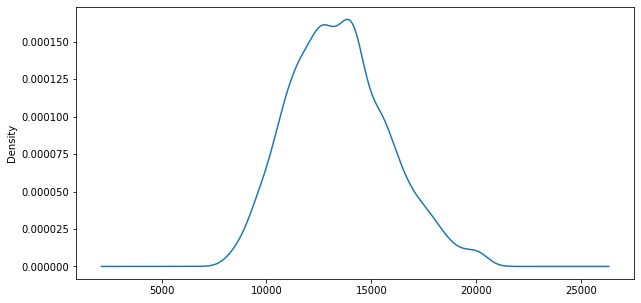

In [283]:
data["duration"].plot(kind='kde', figsize=(10,5))

### Deuxième exemple de visualisation : écart avec le premier

<AxesSubplot:>

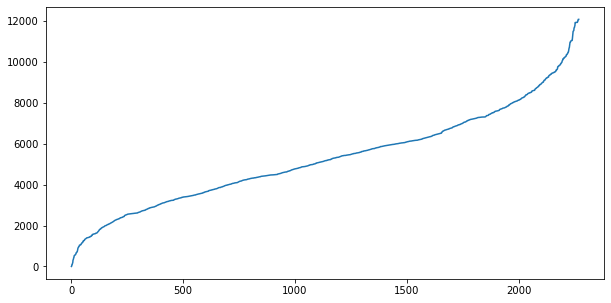

In [284]:
data["time_gap"].dt.total_seconds().plot(figsize=(10,5))

### Troisième exemple de visualisation : histogramme des performances (labels FFA)

<AxesSubplot:>

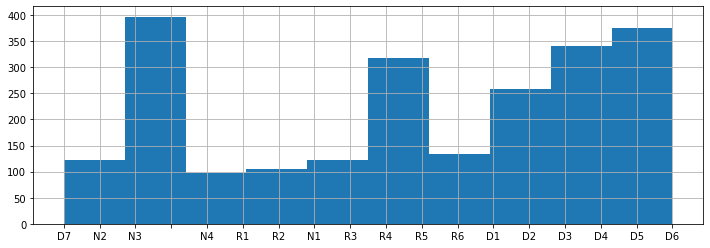

In [285]:
data["Performance"].hist(figsize=(12,4))

<AxesSubplot:>

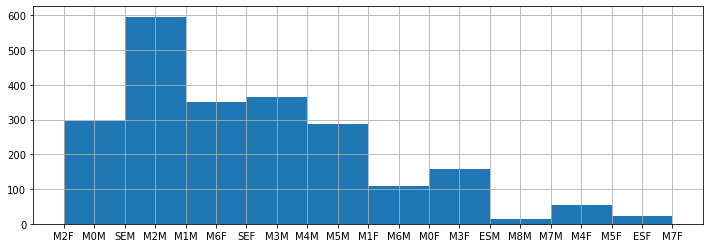

In [286]:
data["Catégorie"].hist(figsize=(12,4))

### Exemple output en csv

In [287]:
#data=data.drop("Club", axis=1)
data.to_csv("France2022_MARATHON_TC.csv", index=False)